# Regresión lineal
***

## Datos: London bike sharing dataset

**Fuente de los datos**: https://www.kaggle.com/datasets/hmavrodiev/london-bike-sharing-dataset?resource=download

**Ejemplo adaptado de:** [acá](https://wisdomml.in/regression-tutorial-bike-sharing-demand-prediction-in-python/)


**Regresión:** Prediccion del número de arriendo de bicicleteas por hora o diario considerando estaciones y temas ambientales.

## Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

In [2]:
!gdown https://drive.google.com/uc?id=1iJC0yN08K-U7cklhM_TFmhgfxpGjot64

Downloading...
From: https://drive.google.com/uc?id=1iJC0yN08K-U7cklhM_TFmhgfxpGjot64
To: /content/london_merged.csv
100% 1.03M/1.03M [00:00<00:00, 24.1MB/s]


In [3]:
df = pd.read_csv("london_merged.csv")
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


Cada columna corresponde a:
* *timestamp*: timestamp
* *cnt*: número de arriendo de bicicletas
* *t1*: temperatura real en grados Celcius
* *t2*: sensación de temperatura en grados Celcius
* *hum*: porcentaje de humedad
* *wind_speed*: velocidad del viento en km/h
* *weather_code*: categoría del clima
* *is_holiday*: dato booleano, 1 es festivo, 0 no es festivo
* *is_weekend*: dato booleano, 1 si es día de fin de semana
* *season*: categoría de la estación, 0-primavera ; 1-verano; 2-otoño; 3-invierno.

Código de *weather_code*: **1** = Despejado ; mayormente despejado pero con algo de neblina/niebla en las cercanías;  **2** = nubes dispersas/pocas nubes; **3** = nubes fragmentadas;  **4** = nublado; **7** = lluvia/chubasco ligero/lluvia ligera;  **10** = lluvia con tormenta; **26** = nevada; **94** = niebla helada

### Separación del timestamp

In [4]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
# mes
df["month"] = df["timestamp"].apply(lambda x:x.month)

# día
df["day"] = df["timestamp"].apply(lambda x:x.day)

# hora
df["hour"] = df["timestamp"].apply(lambda x:x.hour)

# eliminación de columna timestamp
df = df.drop("timestamp", axis=1)

df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,month,day,hour
0,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,1,4,0
1,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,4,1
2,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,1,4,2
3,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,1,4,3
4,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,1,4,4


## Generación de variables ficticias (dummies)
***
Notar que *weather_code* y *season* son variables categóricas, por lo tanto se transforman en variables numéricas usando *One Hot Encoding*.

In [5]:
dummies_w = pd.get_dummies(df["weather_code"], prefix="weather")
df = pd.concat([df,dummies_w], axis=1)
df = df.drop("weather_code", axis=1)

dummies_s = pd.get_dummies(df["season"], prefix="season")
df = pd.concat([df,dummies_s], axis=1)
df = df.drop("season", axis=1)

In [6]:
df.head()

,cnt,t1,t2,hum,wind_speed,is_holiday,is_weekend,month,day,hour,...,weather_2.0,weather_3.0,weather_4.0,weather_7.0,weather_10.0,weather_26.0,season_0.0,season_1.0,season_2.0,season_3.0
0,182,3.0,2.0,93.0,6.0,0.0,1.0,1,4,0,...,False,True,False,False,False,False,False,False,False,True
1,138,3.0,2.5,93.0,5.0,0.0,1.0,1,4,1,...,False,False,False,False,False,False,False,False,False,True
2,134,2.5,2.5,96.5,0.0,0.0,1.0,1,4,2,...,False,False,False,False,False,False,False,False,False,True
3,72,2.0,2.0,100.0,0.0,0.0,1.0,1,4,3,...,False,False,False,False,False,False,False,False,False,True
4,47,2.0,0.0,93.0,6.5,0.0,1.0,1,4,4,...,False,False,False,False,False,False,False,False,False,True


In [7]:
numeric_features = ['t1', 't2', 'hum', 'wind_speed','day','hour','month']
df[numeric_features + ['cnt']].describe()

,t1,t2,hum,wind_speed,day,hour,month,cnt
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,12.468091,11.520836,72.324954,15.913063,15.751981,11.513265,6.514643,1143.101642
std,5.571818,6.615145,14.313186,7.894570,8.793704,6.915893,3.452509,1085.108068
min,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,8.000000,6.000000,63.000000,10.000000,8.000000,6.000000,4.000000,257.000000
50%,12.500000,12.500000,74.500000,15.000000,16.000000,12.000000,7.000000,844.000000
75%,16.000000,16.000000,83.000000,20.500000,23.000000,18.000000,10.000000,1671.750000
max,34.000000,34.000000,100.000000,56.500000,31.000000,23.000000,12.000000,7860.000000


## Histograma

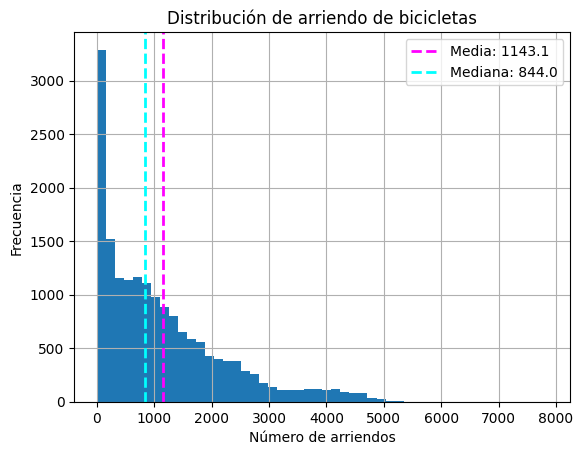

In [8]:
label = df['cnt'] #etiqueta o variable dependiente que queremos predecir

plt.figure()
# Graficar histograma
plt.hist(label, bins=50)
plt.ylabel('Frecuencia')
plt.xlabel('Número de arriendos')
# Agrega lineas para promedio y mediana
plt.axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2, label="Media: " + str(round(label.mean(),2)))
plt.axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2, label = "Mediana: " + str(round(label.median(),2)))
plt.legend()
plt.title("Distribución de arriendo de bicicletas")
plt.grid()
plt.show()

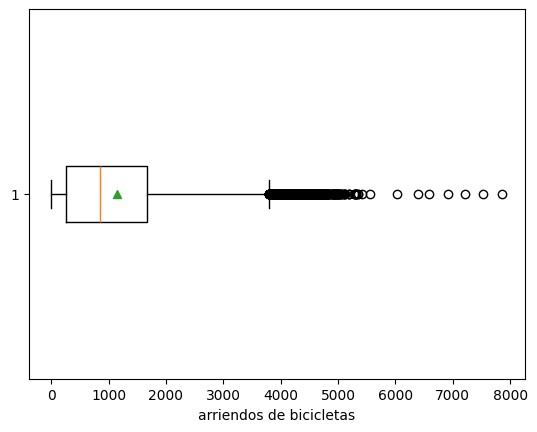

In [9]:
# Graficar boxplot
plt.figure()
bp = plt.boxplot(label,meanline=False,showmeans=True, vert=False)
plt.xlabel('arriendos de bicicletas')
plt.show()

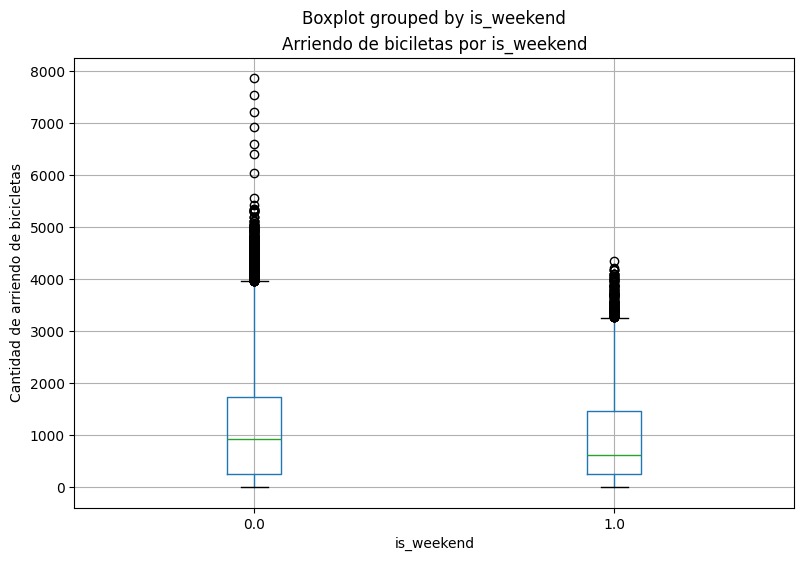

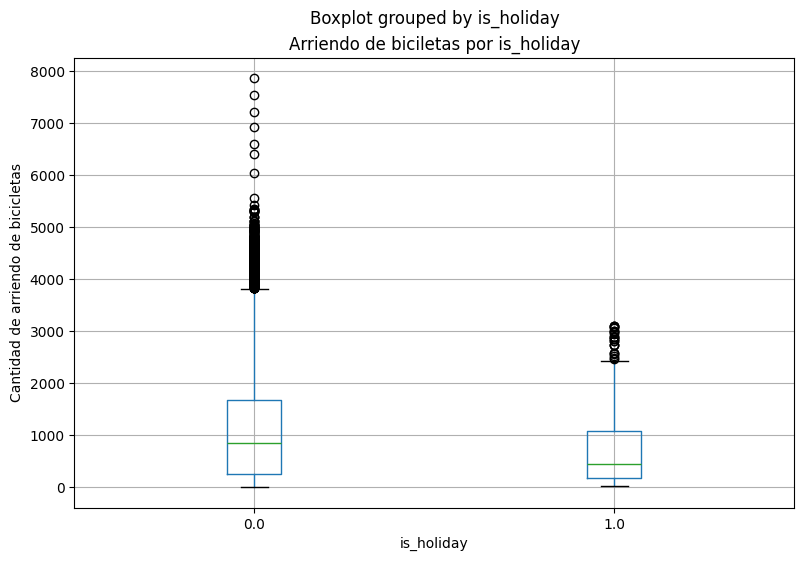

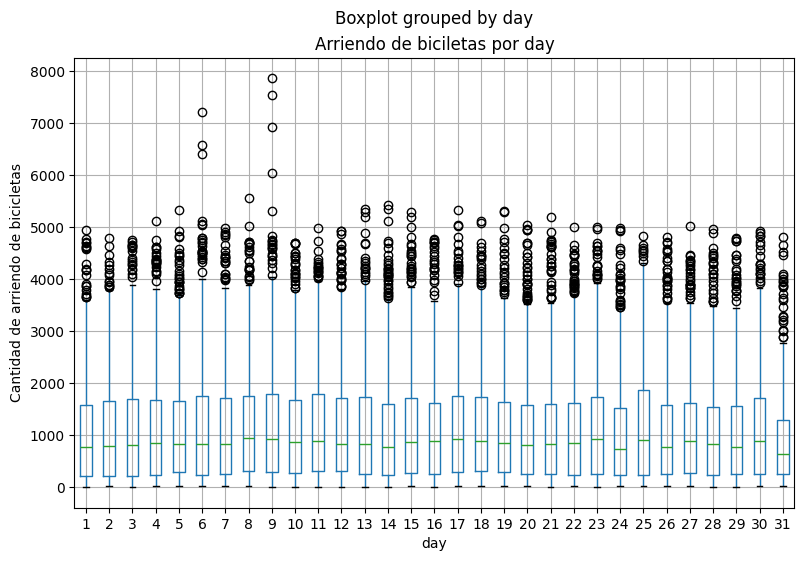

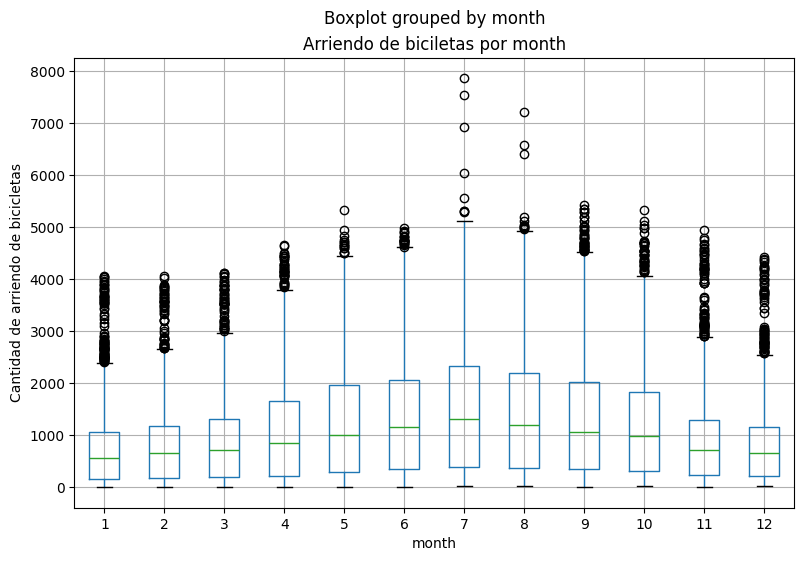

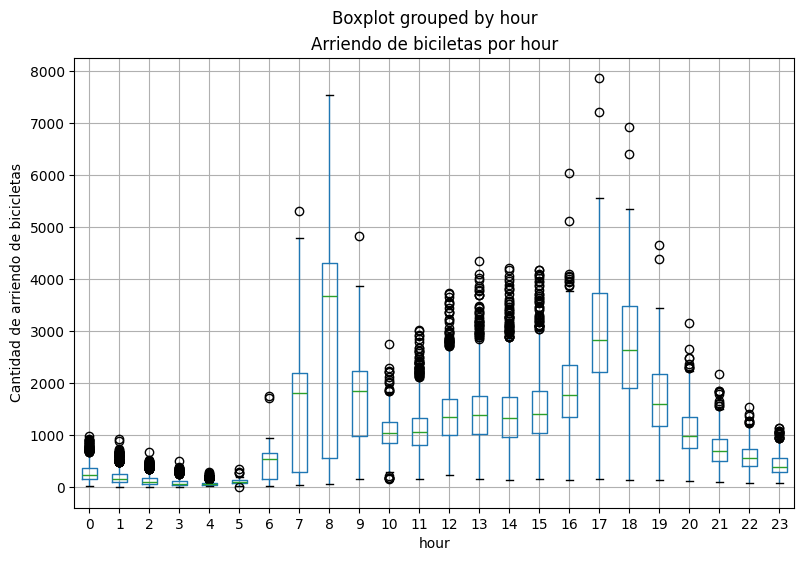

In [10]:
categorical_features = ['is_weekend','is_holiday','day','month','hour']
# plot a boxplot for the label by each categorical feature
for col in categorical_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    df.boxplot(column = 'cnt', by = col, ax = ax)
    ax.set_title('Arriendo de biciletas por ' + col)
    ax.set_ylabel("Cantidad de arriendo de bicicletas")
plt.show()

## Entrenamiento de un modelo de regresión
***
### Matriz $X$ con datos, y vector $y$ con etiquetas

In [11]:
X = df.drop("cnt", axis=1)
y = df["cnt"]

## Training y testing sets

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
print ('Training Set: %d filas\nTest Set: %d filas' % (X_train.shape[0], X_test.shape[0]))

Training Set: 13931 filas
Test Set: 3483 filas


### Entrenamiento

Revisar LinearRegression de scikit-learn [acá](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [13]:
model = LinearRegression().fit(X_train, y_train)

### Predicción

In [14]:
predictions = model.predict(X_test)
print('Valores predichos: ', np.round(predictions)[:10])
print('Valores reales: ' ,y_test[:10].values)

Valores predichos:  [1159. 1841.  963. 2256. 2022. 1827. 1146.  627. 1123. 1132.]
Valores reales:  [ 705  958  497 1392 3073 2190  138 1350 1845 1705]


In [15]:
print("intercepto = ",model.intercept_)
print("coeficientes = ", model.coef_,)

intercepto =  1875.4476955814173
coeficientes =  [  93.68954246  -39.08658353  -23.28316373   -9.85557427 -256.5827186
 -199.43225291    5.20973626   -2.62689987   30.06970577    9.21787273
  268.1011823   279.27699372  -89.85659169  -30.59666635 -469.04947446
   32.90668375  -12.96344265 -107.85096405   65.57043931   55.24396739]


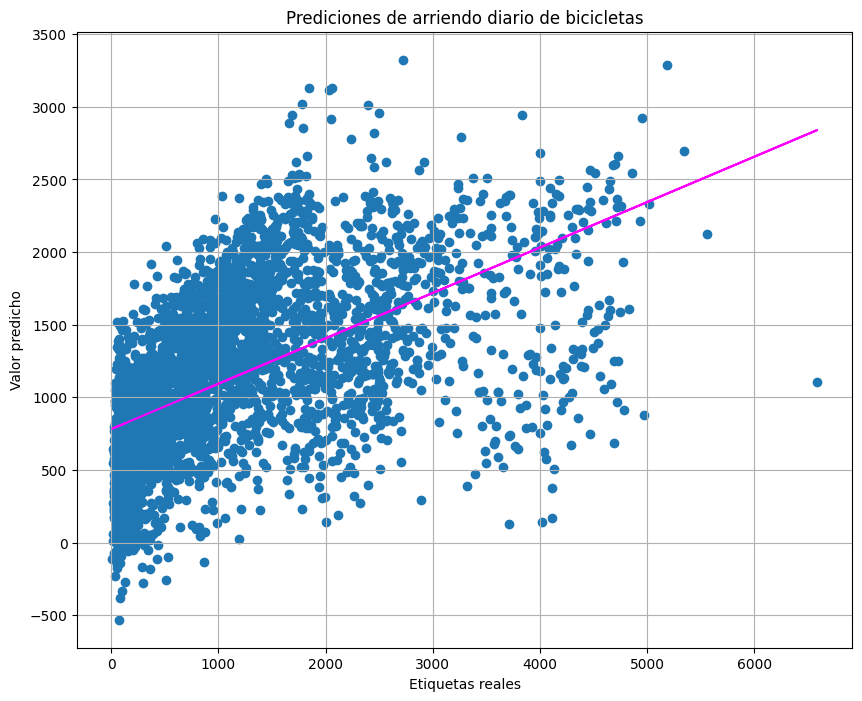

In [16]:
def plot_predicted_true(y_true, y_pred):
    plt.figure(figsize=(10,8))
    plt.scatter(y_true, y_pred)
    plt.xlabel('Etiquetas reales')
    plt.ylabel('Valor predicho')
    plt.title('Prediciones de arriendo diario de bicicletas')

    # linea de regresión entre valor predicho y valor real
    z = np.polyfit(y_test, predictions, 1) #obtiene coeficientes
    p = np.poly1d(z) #aplica coeficientes
    plt.plot(y_test,p(y_test), color='magenta')
    plt.grid()
    plt.show()
    return z, p

z,p = plot_predicted_true(y_test, predictions)

## Desempeño del modelo

In [17]:
mse = mean_squared_error(y_test, predictions)
print("Error cuadrático medio (MSE):", mse)
rmse = np.sqrt(mse)
print("Raíz del error cuadrático medio (RMSE):", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)


Error cuadrático medio (MSE): 814512.2659879726
Raíz del error cuadrático medio (RMSE): 902.5033329511713
R2: 0.31944661704384913


## Aplicando Lasso

Lasso() 

MSE: 814844.4161810011
RMSE: 902.6873302428705
R2: 0.3191690939825593


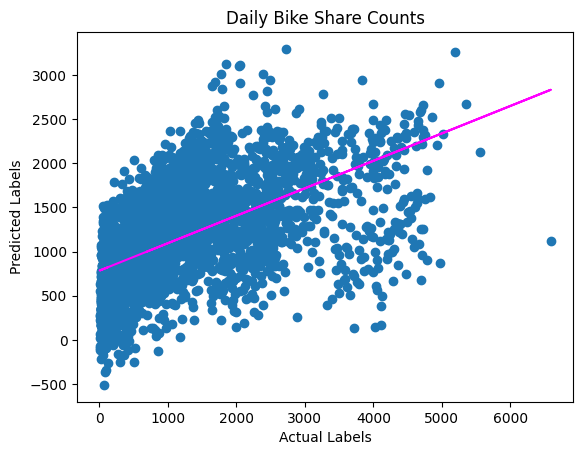

In [18]:
from sklearn.linear_model import Lasso
# Fit a lasso model on the training set
model = Lasso().fit(X_train, y_train)
print (model, "\n")
# Evaluate the model using the test data
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)
# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Counts')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

In [19]:
model.coef_

array([  88.75515993,  -35.75470051,  -23.50659421,   -9.66035206,
       -209.46134657, -193.20667522,    5.42519245,   -2.67336191,
         30.0835981 ,    0.        ,  256.60067884,  268.27402577,
        -83.9456978 ,  -27.74112985,   -0.        ,    0.        ,
        -41.92068016, -126.72057576,   33.78742812,   18.26443861])